# Setup

In [1]:
%pip install transformer_lens==2.11.0 einops eindex-callum jaxtyping huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 124.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 347.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 350.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 349.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 117.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 310.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 249.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 298.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 143.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.4/800.4 kB 192.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 337.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 277.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    F

In [53]:
import einops
import gc
import numpy as np
import re
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from eindex import eindex
from IPython.display import display
from jaxtyping import Float, Int
from torch import Tensor
from tqdm import tqdm
from transformer_lens import (
    ActivationCache,
    FactoredMatrix,
    HookedTransformer,
    HookedTransformerConfig,
    utils,
)
from transformer_lens.hook_points import HookPoint
from typing import Dict, Tuple, List

device = t.device(
    "mps" if t.backends.mps.is_available() else "cuda" if t.cuda.is_available() else "cpu"
)
from huggingface_hub import login

In [ ]:
hf_token = "" # TODO: fill in
login(token=hf_token)
model = HookedTransformer.from_pretrained("meta-llama/Llama-3.1-8B-Instruct")

config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/184 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.4k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

Loaded pretrained model meta-llama/Llama-3.1-8B-Instruct into HookedTransformer


In [18]:
def print_mem():
    # Memory currently allocated by tensors
    print(f"Allocated: {t.cuda.memory_allocated() / 1e9:.2f} GB")
    
    # Memory reserved by the caching allocator (includes unused cached memory)
    print(f"Reserved: {t.cuda.memory_reserved() / 1e9:.2f} GB")

def clear_mem():
    gc.collect()
    t.cuda.empty_cache()

def names_filter(name):
    res = ("resid_pre" in name) or ("resid_mid" in name) \
        or name == utils.get_act_name("resid_post", model.cfg.n_layers-1)
    return res

# Get prompts

In [19]:
import json
from typing import Dict, List

def load_prompt_batches(prompts_file: str, N: int = None) -> Dict[str, List[str]]:
    """
    Load prompts and return as a dictionary for easier access.
    
    Args:
        prompts_file: Path to the JSON file containing prompts
        N: Number of prompt sets to process (if None, processes all)
        
    Returns:
        Dictionary with keys:
        - '1st_person_negative'
        - '1st_person_positive'
        - '3rd_person_negative'
        - '3rd_person_positive'
        Each key maps to a list of prompt strings
    """
    # Load prompts from file
    with open(prompts_file, 'r') as f:
        prompts_data = json.load(f)
    
    # Filter to only process first N prompt sets if specified
    if N is not None:
        prompts_data = [p for p in prompts_data if p['id'] <= N]
    
    # Initialize dictionary
    batches = {
        '1st_person_negative': [],
        '1st_person_positive': [],
        '3rd_person_negative': [],
        '3rd_person_positive': []
    }
    
    # Populate the batches
    for prompt_set in prompts_data:
        for prompt_type in batches.keys():
            batches[prompt_type].append(prompt_set['prompts'][prompt_type])
    
    return batches

In [6]:
# current wd is notebooks/
prompt_batches = load_prompt_batches("../data/prompts.txt")

## Steering vectors

In [33]:
def get_steering_vectors(neg_dataset_path, pos_dataset_path) -> Dict[str, Float[Tensor, "d_model"]]:
    """
    Get steering vectors between two datasets.
    Difference in terms of neg_dataset - pos_dataset.
    """
    activations_neg = t.load(neg_dataset_path)
    activations_pos = t.load(pos_dataset_path)

    steering_vectors = {
      name: (activations_neg[name] - activations_pos[name])
      for name in activations_neg.keys()
    }
    return steering_vectors

## Steering vector analysis

In [21]:
import functools

# Baseline logits
def get_baseline_logits(
  model: HookedTransformer,
  prompt: str
) -> Float[Tensor, "d_vocab"]:
  tokens = model.to_tokens(prompt, prepend_bos=True)
  with t.no_grad():
    logits = model.run_with_hooks(tokens, fwd_hooks=[])
    model.reset_hooks()
    return logits[:, -1, :]

# Add steering vector
def hook_add_steering_vector(
  resid: Float[Tensor, "batch seq_len d_model"],
  hook: HookPoint,
  alpha: float,
  steering_vector: Float[Tensor, "d_model"]
):
  resid += alpha * steering_vector

def add_steering_vector(
  model: HookedTransformer,
  prompt: str,
  steering_vector: Float[Tensor, "d_model"],
  steering_vector_name: str,
  alpha = 1.0,
) -> Float[Tensor, "d_vocab"]:
  """
  Apply steering vector on activation addition.

  Returns the logits of the last token.
  """
  tmp_hook = functools.partial(hook_add_steering_vector, alpha=alpha, steering_vector=steering_vector)

  # Tokenize the prompt
  tokens = model.to_tokens(prompt, prepend_bos=True)

  # Get last token logits
  with t.no_grad():
    logits = model.run_with_hooks(
      tokens,
      fwd_hooks=[(steering_vector_name, tmp_hook)]
    )
    model.reset_hooks()

  final_logits = logits[0, -1, :] # [d_vocab,] TODO: i think?
  return final_logits

# Ablate steering vector
def hook_ablate_steering_vector(
  resid: Float[Tensor, "batch seq_len d_model"],
  hook: HookPoint,
  steering_vector: Float[Tensor, "1 d_model"]
):
  unit_steering_vector = (steering_vector / t.norm(steering_vector)).squeeze(0) # [d_model,]
  coeff = resid @ unit_steering_vector        # [batch, seq_len]
  resid -= coeff.unsqueeze(-1) * unit_steering_vector

def ablate_steering_vector(
  model: HookedTransformer,
  prompt: str,
  steering_vector: Float[Tensor, "d_model"]
) -> Float[Tensor, "d_vocab"]:
  """
  Ablate steering vector on activation subtraction.

  Returns the logits of the last token.
  """
  tmp_hook = functools.partial(hook_ablate_steering_vector, steering_vector=steering_vector)
  tokens = model.to_tokens(prompt, prepend_bos=True)

  with t.no_grad():
    logits = model.run_with_hooks(
      tokens,
      fwd_hooks=[(names_filter, tmp_hook)]
    )
    model.reset_hooks()

  final_logits = logits[0, -1, :]
  return final_logits

# KL divergence w/ and w/out ablation
def kl_divergence(p: Tensor, q: Tensor) -> Tensor:
    """KL(p || q)"""
    log_p = F.log_softmax(p, dim=-1)
    log_q = F.log_softmax(q, dim=-1)
    return F.kl_div(log_q, log_p, reduction='sum', log_target=True)

def kl_divergence_of_last_token(
  model: HookedTransformer,
  prompt: str,
  steering_vector: Float[Tensor, "d_model"],
  baseline_logits: Float[Tensor, "d_vocab"],
) -> float:
  tmp_hook = functools.partial(hook_ablate_steering_vector, steering_vector=steering_vector)
  tokens = model.to_tokens(prompt, prepend_bos=True)

  # Get the last token logits
  with t.no_grad():
    logits_ablation = model.run_with_hooks(
      tokens,
      fwd_hooks=[(names_filter, tmp_hook)]
    )
    model.reset_hooks()
    last_token_logits_ablation = logits_ablation[:, -1, :].squeeze(0).squeeze(0) # [d_vocab,]

  # Compute the KL divergence
  kl_score = kl_divergence(baseline_logits, last_token_logits_ablation)

  return kl_score


In [22]:
import time

def steering_vector_results(
  model: HookedTransformer,
  neg_prompts: List[str],
  pos_prompts: List[str],
  steering_vectors: Dict[str, Float[Tensor, "d_model"]]
):
  res = {}
  start_whole = time.perf_counter()
  
  # Get baseline logits and keep on GPU!
  baseline_logits_dict = {}
  for prompt in pos_prompts:
    baseline_logits_dict[prompt] = get_baseline_logits(model, prompt) # on GPU

  for layer_name, steering_vector in steering_vectors.items():
    print(f"Processing steering vector {layer_name}")
    start = time.perf_counter()
    
    sv = steering_vector.to(model.cfg.device)
    ablate_neg_from_neg_word_freq: List[Tensor] = []
    add_neg_to_pos_word_freq: List[Tensor] = []
    ablate_neg_from_pos_kl_scores = []

    # Ablation
    for prompt in neg_prompts:
      logits = ablate_steering_vector(model, prompt, sv).cpu()
      ablate_neg_from_neg_word_freq.append(logits)
    print(f"Time elapsed for ablation: {time.perf_counter() - start:.3f} s")

    # Addition
    start_add = time.perf_counter()
    for prompt in pos_prompts:
      logits = add_steering_vector(model, prompt, sv, layer_name).cpu()
      add_neg_to_pos_word_freq.append(logits)
    print(f"Time elapsed for addition: {time.perf_counter() - start_add:.3f} s")

    # KL
    start_kl = time.perf_counter()
    for prompt in pos_prompts:
      baseline_logits = baseline_logits_dict[prompt]
      kl_score = kl_divergence_of_last_token(
        model, prompt, sv, baseline_logits
      )
      ablate_neg_from_pos_kl_scores.append(kl_score.item())
    
    ablate_neg_from_pos_avg_kl_score = sum(ablate_neg_from_pos_kl_scores) / len(ablate_neg_from_pos_kl_scores)
    print(f"Time elapsed for kl: {time.perf_counter() - start_kl:.3f} s")

    res[layer_name] = {
      "ablate_neg_from_neg": ablate_neg_from_neg_word_freq,
      "add_neg_to_pos": add_neg_to_pos_word_freq,
      "ablate_neg_from_pos_avg_kl_score": ablate_neg_from_pos_avg_kl_score
    }
    
    # Cleanup between layers
    del sv
    clear_mem()
    
  print(f"Total time elapsed: {time.perf_counter() - start_whole:.3f} s")
  return res

In [ ]:
# Test ablation
neg_prompts = prompt_batches["1st_person_negative"][:]
pos_prompts = prompt_batches["1st_person_positive"][:]
steering_vectors = get_steering_vectors("out/1st_person_negative.pt", "out/1st_person_positive.pt")

res = steering_vector_results(
  model,
  neg_prompts,
  pos_prompts,
  steering_vectors
)

/tmp/ipykernel_3417/2025794274.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations_neg = t.load(neg_dataset_path)
/tmp/ipykernel_3417/2025794274.py:7: FutureWarn

Processing steering vector blocks.0.hook_resid_pre
Time elapsed for ablation: 5.243 s
Time elapsed for addition: 4.210 s
Time elapsed for kl: 5.221 s
Processing steering vector blocks.0.hook_resid_mid
Time elapsed for ablation: 6.077 s
Time elapsed for addition: 4.225 s
Time elapsed for kl: 6.067 s
Processing steering vector blocks.1.hook_resid_pre
Time elapsed for ablation: 6.072 s
Time elapsed for addition: 4.232 s
Time elapsed for kl: 6.067 s
Processing steering vector blocks.1.hook_resid_mid
Time elapsed for ablation: 5.938 s
Time elapsed for addition: 4.234 s
Time elapsed for kl: 5.939 s
Processing steering vector blocks.2.hook_resid_pre
Time elapsed for ablation: 6.062 s
Time elapsed for addition: 4.242 s
Time elapsed for kl: 6.073 s
Processing steering vector blocks.2.hook_resid_mid
Time elapsed for ablation: 6.071 s
Time elapsed for addition: 4.244 s
Time elapsed for kl: 6.084 s
Processing steering vector blocks.3.hook_resid_pre
Time elapsed for ablation: 6.050 s
Time elapsed f

## Get average of results

In [23]:
def get_avg_results(
  steering_vector_results: Dict[str, Dict[str, Tensor]]
):
  res = {}
  for sv in steering_vector_results:
    ablate_logits = steering_vector_results[sv]["ablate_neg_from_neg"]
    add_logits = steering_vector_results[sv]["add_neg_to_pos"]
    kl_score = steering_vector_results[sv]["ablate_neg_from_pos_avg_kl_score"]
    
    avg_add_logits = get_avg_logits(add_logits)
    avg_ablate_logits = get_avg_logits(ablate_logits)
    res[sv] = {
      "ablate_neg_from_neg_avg": avg_ablate_logits,
      "add_neg_to_pos_avg": avg_add_logits,
      "ablate_neg_from_pos_avg_kl_score": kl_score
    }

  return res

## Helper functions to write torch results

In [24]:
def write_steering_results(res, file_name):
    t.save(res, file_name)
def read_steering_results(file_name):
    return t.load(file_name)

In [ ]:
write_steering_results(res, "1_prompt_steering_results_logits.pt")

## Experiment on the closeness of embedding vectors
showed: hurt, angry, sad share about the same cosine similarity as happy -> not a good thing to use

In [ ]:
# Option 1: Use to_single_token (safest)
hurt_token = model.to_single_token(" hurt")   # Ensures single token, returns int
angry_token = model.to_single_token(" angry")
sad_token = model.to_single_token(" sad")
the_token = model.to_single_token(" the")
happy_token = model.to_single_token(" happy")

# Get embeddings correctly
hurt_embedding = model.W_U[:, hurt_token].cpu()    # [d_model]
angry_embedding = model.W_U[:, angry_token].cpu()  # [d_model]
sad_embedding = model.W_U[:, sad_token].cpu()      # [d_model]
the_embedding = model.W_U[:, the_token].cpu()      # [d_model]
happy_embedding = model.W_U[:, happy_token].cpu()  # [d_model]

# Compute similarities
sim_hurt_angry = t.nn.functional.cosine_similarity(
    hurt_embedding.unsqueeze(0), 
    angry_embedding.unsqueeze(0), 
    dim=1
)
sim_hurt_sad = t.nn.functional.cosine_similarity(
    hurt_embedding.unsqueeze(0), 
    sad_embedding.unsqueeze(0), 
    dim=1
)
sim_angry_sad = t.nn.functional.cosine_similarity(
    angry_embedding.unsqueeze(0), 
    sad_embedding.unsqueeze(0), 
    dim=1
)

sim_hurt_the = t.nn.functional.cosine_similarity(
    hurt_embedding.unsqueeze(0), 
    the_embedding.unsqueeze(0), 
    dim=1
)

sim_happy_hurt = t.nn.functional.cosine_similarity(
    happy_embedding.unsqueeze(0), 
    hurt_embedding.unsqueeze(0), 
    dim=1
)

print(f"hurt-angry:  {sim_hurt_angry.item():.4f}")
print(f"hurt-sad:    {sim_hurt_sad.item():.4f}")
print(f"angry-sad:   {sim_angry_sad.item():.4f}")
print(f"hurt-the:    {sim_hurt_the.item():.4f}")
print(f"happy-hurt:  {sim_happy_hurt.item():.4f}")

## Steering vector metrics

In [52]:
def get_logit_diff(
  logits: Float[Tensor, "d_vocab"], 
  token1: List[int],
  token2: List[int]
) -> float:
  return logits[token1].mean() - logits[token2].mean()

def get_avg_logits(
  logits: List[Float[Tensor, "d_vocab"]]
) -> Float[Tensor, "d_vocab"]:
  return t.stack(logits, dim=0).mean(dim=0)

def steering_vector_metrics(
  steering_vector_results: Dict[str, Dict[str, Tensor]],
  hurt_tokens: List[int],
  proud_tokens: List[int]
):
  metrics = {}
  for sv in steering_vector_results:
    ablate_logits = steering_vector_results[sv]["ablate_neg_from_neg_avg"]
    add_logits = steering_vector_results[sv]["add_neg_to_pos_avg"]
    kl_score = steering_vector_results[sv]["ablate_neg_from_pos_avg_kl_score"]

    add_diff = get_logit_diff(add_logits, hurt_tokens, proud_tokens)
    ablate_diff = get_logit_diff(ablate_logits, hurt_tokens, proud_tokens)

    metrics[sv] = {
      "add_diff": add_diff,
      "ablate_diff": ablate_diff,
      "kl_score": kl_score
    }

  return metrics


## Find best steering vectors

In [54]:
def get_layer(
  layer_name: str,
):
  return int(layer_name.split('.')[1])

def get_pass_metrics(
  metrics: Dict[str, Dict[str, Tensor]],
  induce_score_min: float = 0, # exclusive
  kl_score: None | float = None,
  layer_frac: None | float = None,  
) -> Dict[str, Dict[str, Tensor]]:
  res = {}
  for sv in metrics:
    if kl_score is not None and metrics[sv]['kl_score'] > kl_score:
      continue
    if layer_frac is not None and get_layer(sv) < layer_frac * 32:
      continue
    if metrics[sv]['add_diff'] <= induce_score_min:
      continue
    res[sv] = metrics[sv]
  return res


In [55]:
sv_results_1 = read_steering_results("remote/notebooks/out/experiments/1st_person_50_prompts/steering_results_logits_avg.pt")
metrics_1 = steering_vector_metrics(sv_results_1, [33630], [12691]) # frustrated, proud

sv_results_3 = read_steering_results("remote/notebooks/out/experiments/3rd_person_50_prompts/steering_results_logits_avg.pt")
metrics_3 = steering_vector_metrics(sv_results_3, [33630], [12691]) # frustrated, proud

#### (Aside: Plot metrics)

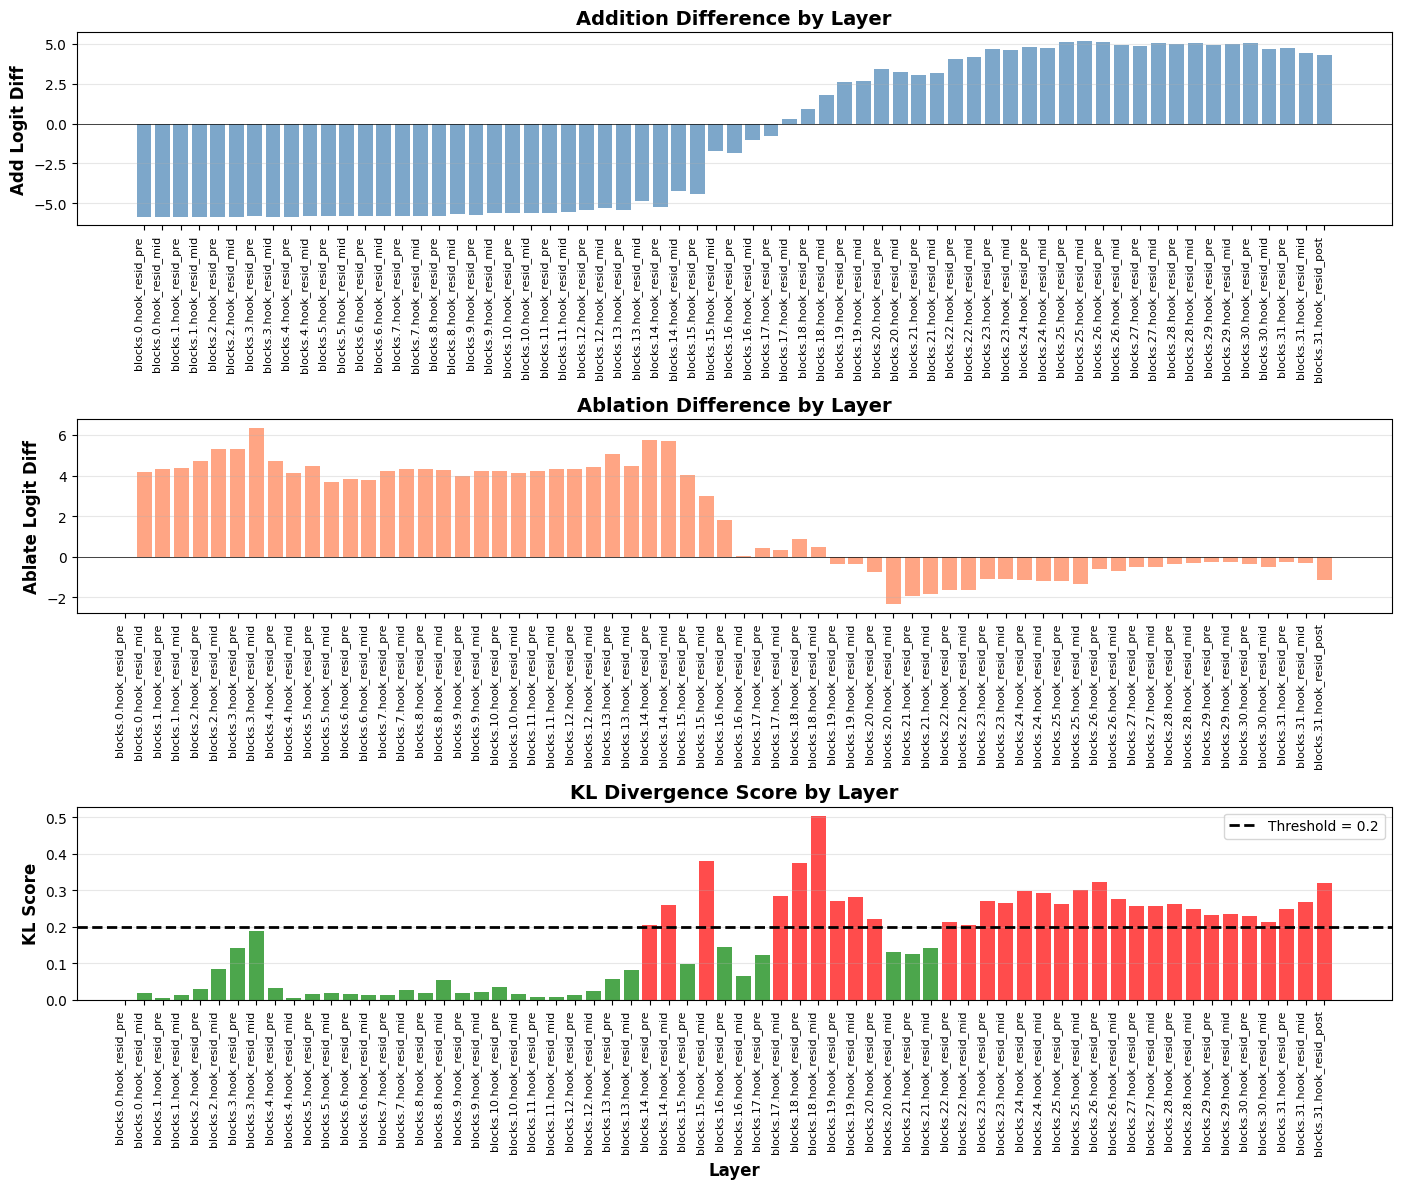


Summary Statistics:
Add Diff    - Mean: -0.8747, Std: 4.7518
Ablate Diff - Mean: nan, Std: nan
KL Score    - Mean: nan, Std: nan

Layers with KL Score > 0.2: 30/65


In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data from metrics_1
layers = list(metrics_1.keys())
add_diff_values = [metrics_1[layer]['add_diff'] for layer in layers]
ablate_diff_values = [metrics_1[layer]['ablate_diff'] for layer in layers]
kl_score_values = [metrics_1[layer]['kl_score'] for layer in layers]

# Create figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: add_diff
axes[0].bar(range(len(layers)), add_diff_values, color='steelblue', alpha=0.7)
axes[0].set_ylabel('Add Logit Diff', fontsize=12, fontweight='bold')
axes[0].set_title('Addition Difference by Layer', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 2: ablate_diff
axes[1].bar(range(len(layers)), ablate_diff_values, color='coral', alpha=0.7)
axes[1].set_ylabel('Ablate Logit Diff', fontsize=12, fontweight='bold')
axes[1].set_title('Ablation Difference by Layer', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Plot 3: kl_score with threshold coloring
threshold = 0.2
colors = ['green' if kl < threshold else 'red' for kl in kl_score_values]

axes[2].bar(range(len(layers)), kl_score_values, color=colors, alpha=0.7)
axes[2].axhline(y=threshold, color='black', linestyle='--', linewidth=2, 
                label=f'Threshold = {threshold}')
axes[2].set_ylabel('KL Score', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Layer', fontsize=12, fontweight='bold')
axes[2].set_title('KL Divergence Score by Layer', fontsize=14, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
axes[2].legend()

# Set x-axis labels for all plots
for ax in axes:
    ax.set_xticks(range(len(layers)))
    ax.set_xticklabels(layers, rotation=90, ha='right', fontsize=8)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\nSummary Statistics:")
print(f"Add Diff    - Mean: {np.mean(add_diff_values):.4f}, Std: {np.std(add_diff_values):.4f}")
print(f"Ablate Diff - Mean: {np.mean(ablate_diff_values):.4f}, Std: {np.std(ablate_diff_values):.4f}")
print(f"KL Score    - Mean: {np.mean(kl_score_values):.4f}, Std: {np.std(kl_score_values):.4f}")
print(f"\nLayers with KL Score > 0.2: {sum(1 for kl in kl_score_values if kl > threshold)}/{len(kl_score_values)}")

## Find steering vectors that pass criteria

In [51]:
# Get layernames that pass
pass_metrics_1 = get_pass_metrics(metrics_1, induce_score_min=0, kl_score=0.20, layer_frac=None)
pass_metrics_3 = get_pass_metrics(metrics_3, induce_score_min=0, kl_score=0.20, layer_frac=None)

# Sort pass_metrics by ablate_diff
pass_metrics_1 = sorted(pass_metrics_1, key=lambda x: pass_metrics_1[x]['ablate_diff'])
pass_metrics_3 = sorted(pass_metrics_3, key=lambda x: pass_metrics_3[x]['ablate_diff'])

# Print steering vectors that pass
len(pass_metrics_1)
len(pass_metrics_3)
print(pass_metrics_1)
print(pass_metrics_3)

['blocks.20.hook_resid_mid', 'blocks.21.hook_resid_pre', 'blocks.21.hook_resid_mid']
['blocks.22.hook_resid_pre', 'blocks.20.hook_resid_mid', 'blocks.21.hook_resid_mid', 'blocks.19.hook_resid_pre']


In [ ]:
# Cross performance of vectors that are not in each other's best performing vectors
best_perform_3_not_in_1 = [sv for sv in pass_metrics_3 if sv not in pass_metrics_1]
print("Best performing 3rd person steering vectors not in 1st person:")
print(best_perform_3_not_in_1)
for sv in best_perform_3_not_in_1:
  print(sv)
  print(metrics_1[sv])
print()

best_performing_1_not_in_3 = [sv for sv in pass_metrics_1 if sv not in pass_metrics_3]
print("Best performing 1st person steering vectors not in 3rd person:")
print(best_performing_1_not_in_3)
for sv in best_performing_1_not_in_3:
  print(sv)
  print(metrics_3[sv])
print()

Best performing 3rd person steering vectors not in 1st person:
['blocks.22.hook_resid_pre', 'blocks.19.hook_resid_pre']
blocks.22.hook_resid_pre
{'add_diff': tensor(4.0445), 'ablate_diff': tensor(-1.6517), 'kl_score': 0.21421765998005868}
blocks.19.hook_resid_pre
{'add_diff': tensor(2.6204), 'ablate_diff': tensor(-0.3569), 'kl_score': 0.27102911099791527}

Best performing 1st person steering vectors not in 3rd person:
['blocks.21.hook_resid_pre']
blocks.21.hook_resid_pre
{'add_diff': tensor(2.0349), 'ablate_diff': tensor(-1.7265), 'kl_score': 0.20220992617309094}



## Plot cosine similarity

                          blocks.19.hook_resid_pre  blocks.20.hook_resid_mid  \
blocks.19.hook_resid_pre                  0.903327                  0.770833   
blocks.20.hook_resid_mid                  0.763689                  0.935580   
blocks.21.hook_resid_mid                  0.694774                  0.829788   
blocks.21.hook_resid_pre                  0.689839                  0.842464   
blocks.22.hook_resid_pre                  0.647583                  0.761577   

                          blocks.21.hook_resid_mid  blocks.21.hook_resid_pre  \
blocks.19.hook_resid_pre                  0.700169                  0.692811   
blocks.20.hook_resid_mid                  0.823827                  0.833775   
blocks.21.hook_resid_mid                  0.940155                  0.908592   
blocks.21.hook_resid_pre                  0.911710                  0.937863   
blocks.22.hook_resid_pre                  0.841753                  0.813577   

                          blocks.22.ho

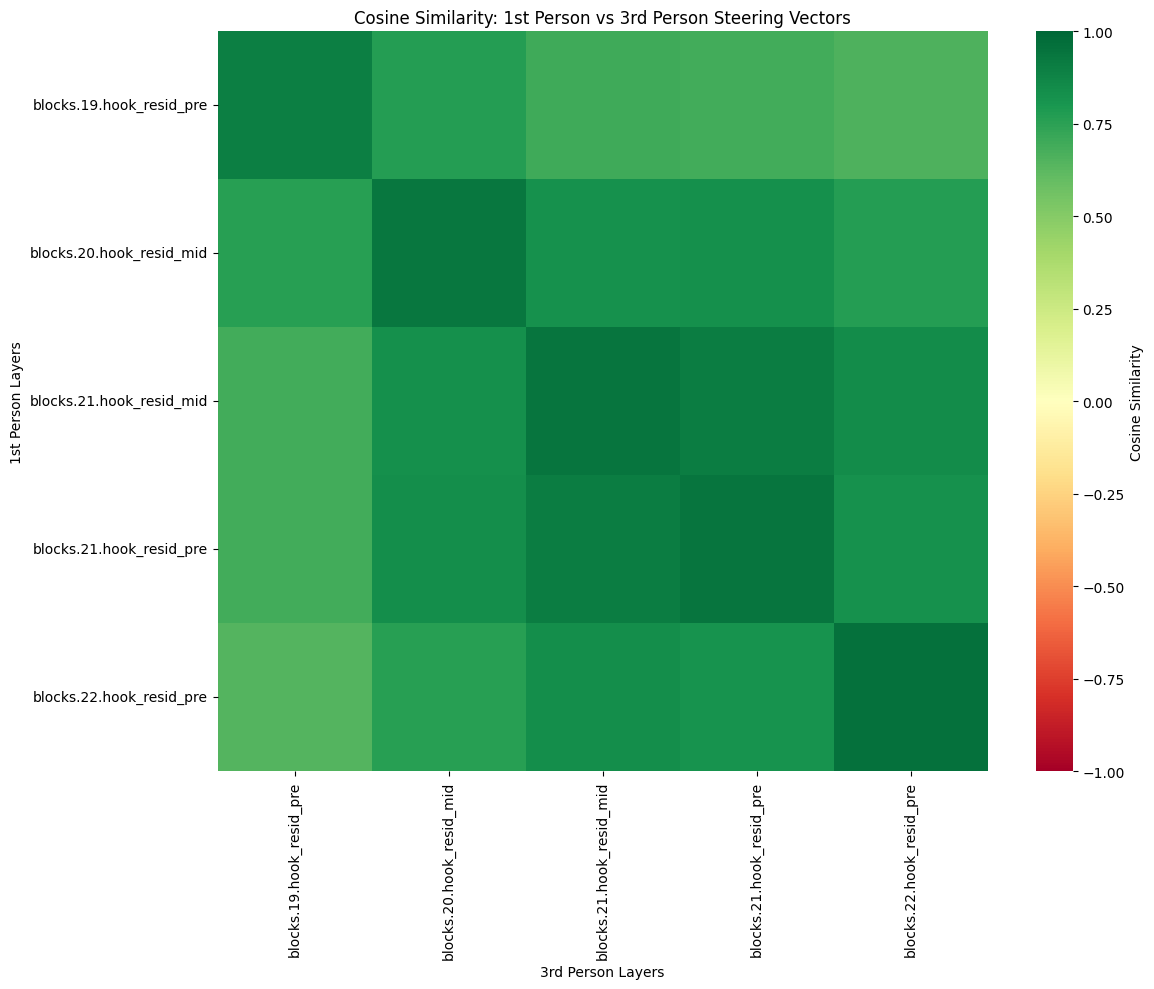

In [30]:
import torch as t
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have:
# steering_vectors_1 = dict of 1st person steering vectors
# steering_vectors_3 = dict of 3rd person steering vectors

def compute_similarity_grid(
  sv_dict_1,
  sv_dict_3,
  sv_list
):
    """
    Compute cosine similarity grid between two sets of steering vectors.
    
    Returns:
        DataFrame with rows=1st person SVs, cols=3rd person SVs
    """
    # Get sorted layer names for consistent ordering
    layers = sorted(sv_list)
    
    # Initialize similarity matrix
    similarity_matrix = np.zeros((len(layers), len(layers)))
    
    # Compute pairwise cosine similarities
    for i, layer_1 in enumerate(layers):
        sv_1 = sv_dict_1[layer_1].flatten()
        for j, layer_3 in enumerate(layers):
            sv_3 = sv_dict_3[layer_3].flatten()
            
            # Compute cosine similarity
            similarity = F.cosine_similarity(
                sv_1.unsqueeze(0), 
                sv_3.unsqueeze(0)
            ).item()
            
            similarity_matrix[i, j] = similarity
    
    # Create DataFrame for easier viewing
    df = pd.DataFrame(
        similarity_matrix,
        index=layers,
        columns=layers
    )
    
    return df

# Get steering
sv_list = list(set(pass_metrics_1 + pass_metrics_3))

steering_vectors_1 = get_steering_vectors("remote/notebooks/out/activations/1st_person_negative.pt", "remote/notebooks/out/activations/1st_person_positive.pt")
steering_vectors_3 = get_steering_vectors("remote/notebooks/out/activations/3rd_person_negative.pt", "remote/notebooks/out/activations/3rd_person_positive.pt")

################
# Compute similarity grid
similarity_df = compute_similarity_grid(steering_vectors_1, steering_vectors_3, sv_list)

print(similarity_df)
is_symmetric = np.allclose(similarity_df.values, similarity_df.values.T)

# Display
print("Cosine Similarity Grid (1st person × 3rd person)")
print(similarity_df)

# Find highest similarity pairs
max_sim = similarity_df.max().max()
max_location = similarity_df.stack().idxmax()
print(f"\nHighest similarity: {max_sim:.4f}")
print(f"Between: {max_location[0]} (1st) and {max_location[1]} (3rd)")

# Visualize as heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    similarity_df, 
    annot=False,  # Set True to show values in cells
    cmap='RdYlGn',  # Red-Yellow-Green colormap
    center=0,
    vmin=-1, 
    vmax=1,
    cbar_kws={'label': 'Cosine Similarity'}
)
plt.title('Cosine Similarity: 1st Person vs 3rd Person Steering Vectors')
plt.xlabel('3rd Person Layers')
plt.ylabel('1st Person Layers')
plt.tight_layout()
plt.show()


In [ ]:
# Extract Cosine Similarity Matrix
array_2x2 = similarity_df.iloc[:, :].values
print(array_2x2)

[[0.90332699 0.7708329  0.70016873 0.69281077 0.66141963]
 [0.76368856 0.93557996 0.82382679 0.8337754  0.76831937]
 [0.69477427 0.82978845 0.94015527 0.90859222 0.85127926]
 [0.68983948 0.84246361 0.91170967 0.93786252 0.82438803]
 [0.64758301 0.76157665 0.84175277 0.81357712 0.95602918]]


In [ ]:

# 1st person negative
print(model.to_tokens(" frustrated")) # 33630
print(model.to_tokens(" disappointed")) # 25406
print(model.to_tokens(" embarrassed")) # 49230
print(model.to_tokens(" frustration")) # 33086
print(model.to_tokens(" nervous")) # 23418

print(model.to_tokens(" proud")) # 12691
print(model.to_tokens(" confident")) # 16913
print(model.to_tokens(" happy")) # 6380
print(model.to_tokens(" satisfied")) # 20097
print(model.to_tokens(" gratitude")) # 46135

# 3rd person negative
print(model.to_tokens(" frustrated")) # 33630
print(model.to_tokens(" disappointed")) # 25406
print(model.to_tokens(" embarrassed")) # 49230
print(model.to_tokens(" anger")) # 33086
print(model.to_tokens(" disappointment")) # 23418

# 3rd person positive
print(model.to_tokens(" pride")) # 12691
print(model.to_tokens(" happy")) # 6380
print(model.to_tokens(" gratitude")) # 46135
print(model.to_tokens(" confident")) # 16913
print(model.to_tokens(" satisfied")) # 20097

{'blocks.0.hook_resid_pre': {'add_diff': tensor(-1.7715),
  'ablate_diff': tensor(nan),
  'kl_score': nan},
 'blocks.0.hook_resid_mid': {'add_diff': tensor(-1.7692),
  'ablate_diff': tensor(-1.4834),
  'kl_score': 0.019295627661049367},
 'blocks.1.hook_resid_pre': {'add_diff': tensor(-1.7708),
  'ablate_diff': tensor(-1.7024),
  'kl_score': 0.005869881119579077},
 'blocks.1.hook_resid_mid': {'add_diff': tensor(-1.7703),
  'ablate_diff': tensor(-1.7559),
  'kl_score': 0.011753082992509007},
 'blocks.2.hook_resid_pre': {'add_diff': tensor(-1.7600),
  'ablate_diff': tensor(-2.3048),
  'kl_score': 0.029897760059684517},
 'blocks.2.hook_resid_mid': {'add_diff': tensor(-1.7670),
  'ablate_diff': tensor(-2.2472),
  'kl_score': 0.08497972846031189},
 'blocks.3.hook_resid_pre': {'add_diff': tensor(-1.7719),
  'ablate_diff': tensor(-2.4209),
  'kl_score': 0.14056021317839623},
 'blocks.3.hook_resid_mid': {'add_diff': tensor(-1.7800),
  'ablate_diff': tensor(-2.4698),
  'kl_score': 0.188648453950

## Logits on positive/negative categorization tasks

In [56]:
import json
pos_neg_prompt_batches = load_prompt_batches("../data/converted_prompts.txt")
steering_vectors = get_steering_vectors("out/activations/1st_person_negative.pt", "out/activations/1st_person_positive.pt")

/tmp/ipykernel_2642/2025794274.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  activations_neg = t.load(neg_dataset_path)
/tmp/ipykernel_2642/2025794274.py:7: FutureWarn

In [60]:
def get_logits(prompt, model):
  tokens = model.to_tokens(prompt, prepend_bos=True)
  with t.no_grad():
    logits = model.run_with_hooks(tokens)
  return logits

from collections import defaultdict
res = defaultdict(int)
for prompt in tqdm(pos_neg_prompt_batches['1st_person_negative']):
    baseline_logits = get_logits(prompt, model)[0, -1, :]
    baseline_diff = get_logit_diff(baseline_logits, 8389, 6928)
    res["baseline"] += baseline_diff

    # ['blocks.22.hook_resid_pre', 'blocks.21.hook_resid_mid', 'blocks.21.hook_resid_pre', 'blocks.20.hook_resid_mid', 'blocks.19.hook_resid_pre']:
    for sv_name in ['blocks.22.hook_resid_pre', 'blocks.21.hook_resid_mid', 'blocks.21.hook_resid_pre', 'blocks.20.hook_resid_mid', 'blocks.19.hook_resid_pre']:
        sv = steering_vectors[sv_name].to(model.cfg.device)
        sv = sv.squeeze(0)
    
        logits = ablate_steering_vector(
            model,
            prompt,
            sv
        )
        logit_diff = get_logit_diff(logits, 8389, 6928)
        res[sv_name] += logit_diff


100%|██████████| 50/50 [00:33<00:00,  1.47it/s]


In [61]:
# Get average
for sv_name, logit_diff_sum in res.items():
    res[sv_name] /= len(pos_neg_prompt_batches['1st_person_negative'])

In [ ]:
ablate 1st person hurt from 1st person negative:
defaultdict(int,
            {'baseline': tensor(3.3805, device='cuda:0'),
             'blocks.22.hook_resid_pre': tensor(2.3241, device='cuda:0'),
             'blocks.21.hook_resid_mid': tensor(1.7229, device='cuda:0'),
             'blocks.21.hook_resid_pre': tensor(1.8801, device='cuda:0'),
             'blocks.20.hook_resid_mid': tensor(1.2506, device='cuda:0'),
             'blocks.19.hook_resid_pre': tensor(0.8717, device='cuda:0')})

ablate 1st person hurt from 1st person positive:
defaultdict(int,
            {'baseline': tensor(-1.4103, device='cuda:0'),
             'blocks.22.hook_resid_pre': tensor(-0.6375, device='cuda:0'),
             'blocks.21.hook_resid_mid': tensor(-0.9481, device='cuda:0'),
             'blocks.21.hook_resid_pre': tensor(-1.0291, device='cuda:0'),
             'blocks.20.hook_resid_mid': tensor(-1.4753, device='cuda:0'),
             'blocks.19.hook_resid_pre': tensor(-1.7139, device='cuda:0')})

ablate 3rd person hurt from 3rd person negative:
defaultdict(int,
            {'baseline': tensor(2.1896, device='cuda:0'),
             'blocks.22.hook_resid_pre': tensor(1.4301, device='cuda:0'),
             'blocks.21.hook_resid_mid': tensor(0.9532, device='cuda:0'),
             'blocks.21.hook_resid_pre': tensor(1.0458, device='cuda:0'),
             'blocks.20.hook_resid_mid': tensor(0.5659, device='cuda:0'),
             'blocks.19.hook_resid_pre': tensor(0.2656, device='cuda:0')})

ablate 3rd person hurt from 3rd person positive:
defaultdict(int,
            {'baseline': tensor(-1.7911, device='cuda:0'),
             'blocks.22.hook_resid_pre': tensor(-0.8018, device='cuda:0'),
             'blocks.21.hook_resid_mid': tensor(-1.0919, device='cuda:0'),
             'blocks.21.hook_resid_pre': tensor(-1.1893, device='cuda:0'),
             'blocks.20.hook_resid_mid': tensor(-1.5687, device='cuda:0'),
             'blocks.19.hook_resid_pre': tensor(-1.8345, device='cuda:0')})


ablate 1st person hurt from 3rd person negative: (for fun)
defaultdict(int,
            {'baseline': tensor(2.1896, device='cuda:0'),
             'blocks.20.hook_resid_mid': tensor(0.5659, device='cuda:0'),
             'blocks.21.hook_resid_pre': tensor(1.0458, device='cuda:0'),
             'blocks.21.hook_resid_mid': tensor(0.9532, device='cuda:0'),
             'blocks.19.hook_resid_pre': tensor(0.2656, device='cuda:0')})


defaultdict(int,
            {'baseline': tensor(-1.4103, device='cuda:0'),
             'blocks.20.hook_resid_mid': tensor(-1.4753, device='cuda:0'),
             'blocks.21.hook_resid_pre': tensor(-1.0291, device='cuda:0'),
             'blocks.21.hook_resid_mid': tensor(-0.9481, device='cuda:0'),
             'blocks.19.hook_resid_pre': tensor(-1.7139, device='cuda:0')})

In [ ]:
def avg_activation_adition(
  model,
  sv,
  sv_name,
  prompts
):
  res = {}
  for prompt in prompts:
    # ['blocks.22.hook_resid_pre', 'blocks.21.hook_resid_mid', 'blocks.21.hook_resid_pre', 'blocks.20.hook_resid_mid', 'blocks.19.hook_resid_pre']:
    
    avg_logits = t.ones(model.cfg.d_model)
    for sv_name in ['blocks.22.hook_resid_pre', 'blocks.21.hook_resid_mid', 'blocks.21.hook_resid_pre', 'blocks.20.hook_resid_mid', 'blocks.19.hook_resid_pre']:
        sv = steering_vectors[sv_name].to(model.cfg.device)
        sv = sv.squeeze(0)
    
        logits = ablate_steering_vector(
            model,
            prompt,
            sv
        )


## display apply steering logits

In [74]:
import pandas as pd
import torch as t
import dataframe_image as dfi

# Convert to DataFrame
data = {
    'blocks.20.hook_resid_mid': {'add_diff': t.tensor(3.2072), 'ablate_diff': t.tensor(-2.3176), 'kl_score': 0.13025329247117043},
    'blocks.21.hook_resid_pre': {'add_diff': t.tensor(3.0547), 'ablate_diff': t.tensor(-1.9543), 'kl_score': 0.12603289686143399},
    'blocks.21.hook_resid_mid': {'add_diff': t.tensor(3.1844), 'ablate_diff': t.tensor(-1.8152), 'kl_score': 0.14162033550441266}
}
# data = {'blocks.19.hook_resid_pre': {'add_diff': t.tensor(2.0963), 'ablate_diff': t.tensor(-1.5083), 'kl_score': 0.1896424300223589}, 'blocks.20.hook_resid_mid': {'add_diff': t.tensor(2.0962), 'ablate_diff': t.tensor(-2.1421), 'kl_score': 0.1751341713964939}, 'blocks.21.hook_resid_mid': {'add_diff': t.tensor(2.0646), 'ablate_diff': t.tensor(-2.0134), 'kl_score': 0.17042094849050046}, 'blocks.22.hook_resid_pre': {'add_diff': t.tensor(2.7889), 'ablate_diff': t.tensor(-2.2935), 'kl_score': 0.1747595550864935}}


df = pd.DataFrame(data).T
df['add_diff'] = df['add_diff'].apply(lambda x: x.item() if isinstance(x, t.Tensor) else x)
df['ablate_diff'] = df['ablate_diff'].apply(lambda x: x.item() if isinstance(x, t.Tensor) else x)

# Apply color gradients - different colormap for each column
styled_df = (df.style
    .background_gradient(subset=['add_diff'], cmap='Greens')
    .background_gradient(subset=['ablate_diff'], cmap='Reds_r')  # _r for reverse
    .background_gradient(subset=['kl_score'], cmap='Blues')
    .format({'add_diff': '{:.4f}', 'ablate_diff': '{:.4f}', 'kl_score': '{:.4f}'})
    .set_caption("1st-Person: Steering Vector Metrics")
)

# Export to image
styled_df

,add_diff,ablate_diff,kl_score
blocks.20.hook_resid_mid,3.2072,-2.3176,0.1303
blocks.21.hook_resid_pre,3.0547,-1.9543,0.1260
blocks.21.hook_resid_mid,3.1844,-1.8152,0.1416
